In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")
import pandas as pd2
import numpy as np
from sklearn.datasets import load_linnerud
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from physlearn import Regressor
import pandas as pd

In [8]:
# Transfer into xlsx format for convenience
pd.read_csv("./data_original.csv").to_excel("data_original.xlsx",index=False)

In [9]:
df = pd.read_excel("data_original.xlsx")

In [10]:
df.sample(3)

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
1287,10.1039/C4CP01679C,7/2/2014,Physical Chemistry Chemical Physics,"The solvatochromic, spectral, and geometrical ...",DMF,0.0,NaN,rsc_cde_tables,CN(C)C=O,1.431,n
2902,10.1016/j.jlumin.2018.04.026,4/12/2018,Journal of Luminescence,EU2O3DOPEDBRIGHTORANGEREDLUMINESCENTLITHIUMALU...,Oxygen,0.0,NaN,el_cde_tables,O,1.3634,n
1992,10.1016/j.jct.2004.09.021,1/5/2005,The Journal of Chemical Thermodynamics,PHYSICALPROPERTIESANISOLENALKANESTEMPERATURESB...,Octane,0.0,NaN,el_cde_tables,NaN,1.3947,nD


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     5000 non-null   object 
 1   Date                    4593 non-null   object 
 2   Journal                 4593 non-null   object 
 3   Title                   4593 non-null   object 
 4   Name                    4996 non-null   object 
 5   measurement_error       5000 non-null   float64
 6   measurement_wavelength  588 non-null    object 
 7   measurement_method      5000 non-null   object 
 8   normalised_name         2946 non-null   object 
 9   raw_value               5000 non-null   object 
 10  specifier               5000 non-null   object 
dtypes: float64(1), object(10)
memory usage: 429.8+ KB


In [12]:
# Для удобста ватаскивания значений через iloc
column_index_dic = {col_name:index for index,col_name in enumerate(df.columns)}

In [13]:
# В столбце "Name" есть пропущенные значения - 4 штуки 
print("Missed values ['Name']: ", df["Name"].isna().sum())
# В столбце "Name", заполним их исходя их столбца "normalized name"

import requests 

def convert_smiles_to_name(smi):
    try:
        url ="https://cactus.nci.nih.gov/chemical/structure/" + smi+"/iupac_name" 
        res = requests.get(url)
        return res.text.strip()
    except:
        return 'name not found'
    
for index in df[df["Name"].isna()].index:
    df.iloc[index,4] = convert_smiles_to_name(df.iloc[index,column_index_dic["normalised_name"]])


Missed values ['Name']:  4


In [14]:
# Теперь заполним пропуски в "normalised_name" через "name"

# В столбце "Name" есть пропущенные значения - 4 штуки 
print("Missed values ['normalised_name']: ", df["normalised_name"].isna().sum())
# В столбце "Name", заполним их исходя их столбца "normalized name"

def convert_names_to_smiles(norm_name):
    try:
        url ="https://cactus.nci.nih.gov/chemical/structure/" + norm_name+"/smiles" 
        res = requests.get(url)
        return res.text.strip()
    except:
        return 'name not found'
 
for index in df[df["normalised_name"].isna()].index:
    df.iloc[index,column_index_dic["normalised_name"]] = convert_names_to_smiles(df.iloc[index,column_index_dic["Name"]])


Missed values ['normalised_name']:  2054


In [15]:
# на всякий случай, если есть, избавляемся от пробелов по краям строк
df["DOI"] = df["DOI"].apply(lambda x: x.strip())

## Обработка DOIs - первая интераця 

In [20]:
# Обраюотка DOI
# Если есть пробелы, то начинаем обработку 
from bs4 import BeautifulSoup
# индексы строк с пробелами в DOI
index_rows= df[df["DOI"].apply(lambda x: " " in x)].index

slice_wrong_DOIs = df.iloc[index_rows,column_index_dic["DOI"]]
correct_slice_DOIs = []
for doi in slice_wrong_DOIs.values:
    try:
        correct_doi = []
        for symbol in doi:
            correct_doi.append(symbol)
            # все DOI длинее 11 символов)
            if len(correct_doi)>11:
                response = requests.get(f"https://sci-hub.ru/{''.join(correct_doi)}")
                tag_value = BeautifulSoup(response.content, 'html.parser').find('title').get_text()
                if tag_value != "Sci-Hub: статья не найдена":
                    correct_slice_DOIs.append("".join(correct_doi))
                    break
    except:
        print("nothing")

# Вставляем исправленные значения в DOI
df.iloc[index_rows,column_index_dic["DOI"]] = correct_slice_DOIs

In [21]:
# Проверяем, какие статьи не ищутся и вытаскиваем индекс строк, таких статей
responces = []
doi_problems = []
for doi in df["DOI"]:
    response = requests.get(f"https://sci-hub.ru/{doi}")
    tag_value = BeautifulSoup(response.content, 'html.parser').find('title').get_text()
    if tag_value == "Sci-Hub: статья не найдена":
        doi_problems.append(doi)
    responces.append(tag_value)

In [22]:
# Проблемнеы DOIs, есть дубликаты - удаляем
doi_problems = set(doi_problems)

In [24]:
# Собственно проблемные DOIs

# План такой: убрать слова после цифр, эти DOIs прогнать через sci-hub
# обновлять journal, title и date через crossref

processed_doi_problems = dict()
for doi in doi_problems:
    uppers = [l for l in doi[::-1] if l.isupper()]
    if len(uppers)>0: 
        processed_doi_problems[doi] = doi[:doi.find(uppers[0])]
    else:
        processed_doi_problems[doi] = doi

In [26]:
# Проверяем обработанные статьи ячейкой выше processed_doi_problems

problematic_doi = []
for doi in list(processed_doi_problems.values()):
    response = requests.get(f"https://api.crossref.org/works/{doi}")
    if response.ok:
        data = response.json()["message"]
        print(f"Title: {data['title'][0]}")
        print(f"Publication Date: {data['created']['date-parts'][0][0]}")
        print(f"Journal: {data['container-title'][0]}")
        print(f"DOI: {data['DOI']}")
    else:
        problematic_doi.append(doi)
        print("DOI not found.")

Title: Heat treatment effect on the structural and optical properties of AgInSe2 thin films
Publication Date: 2002
Journal: Vacuum
DOI: 10.1016/s0042-207x(01)00417-1
Title: The light transmission and distribution in an optical fiber coated with TiO2 particles
Publication Date: 2003
Journal: Chemosphere
DOI: 10.1016/s0045-6535(02)00641-0
DOI not found.
Title: Theoretical study of structural, electronic and optical properties of InxGa1-xN alloys
Publication Date: 2018
Journal: Optik
DOI: 10.1016/j.ijleo.2018.08.083
Title: The research on syntheses and properties of novel epoxy/polymercaptan curing optical resins with high refractive indices
Publication Date: 2002
Journal: Polymer
DOI: 10.1016/s0032-3861(01)00573-0
Title: Realization of tunable optical channel drop filter based on photonic crystal octagonal shaped structure
Publication Date: 2018
Journal: Optik
DOI: 10.1016/j.ijleo.2018.06.146
Title: High-performance bimetallic film surface plasmon resonance sensor based on film thickness

In [27]:
# Проблемные статьи))
print(problematic_doi)

['10.3389/fpls.2014.00', '10.1039/C6NR08470', '10.1039/C6TC05201', '10.1038/ncomms8']


In [28]:
# Заменяем старые DOIs новыми, 
# но остается два неразрешенных DOIs - ['10.1038/srep28', '10.3389/fpls.2014.00']
for key,value in processed_doi_problems.items():
    df.loc[df["DOI"]==key,"DOI"] = value

In [29]:
# ['10.3389/fpls.2014.00', '10.1039/C6NR08470', '10.1039/C6TC05201', '10.1038/ncomms8'] удаляем эти DOIs (строки)
for doi_prob in problematic_doi:
    df = df.drop(df[df["DOI"]==doi_prob].index)

In [45]:
# Заполянем пропуски в (Date, Journal, Title)
# Индексы пропусков у них одинаковые

# Индексы пропусков у них одинаковые
missed_index = df[df["Journal"].isna()].index

In [47]:
# Создаем список, который потом заполнить пропуски
problematic_doi_2 = []
values_fill = []
for index in missed_index:
    response = requests.get(f"https://api.crossref.org/works/{df.loc[index,'DOI']}")
    if response.ok:
        data = response.json()["message"]
        values_fill.append([data['created']['date-parts'][0][0],
                            data['container-title'][0],data['title'][0]])
    else:
        problematic_doi_2.append(df.loc[index,'DOI'])
        print("DOI not found.")

DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.
DOI not found.


In [49]:
# Удаляем эти DOIs (строки)
for doi_prob in problematic_doi_2:
    df = df.drop(df[df["DOI"]==doi_prob].index)

In [51]:
df.to_excel("data_mod1.xlsx")

In [3]:
df = pd.read_excel("data_mod1.xlsx")

In [4]:
# Индексы пропусков у них одинаковые - но изменились после удаления, поэтому заново
missed_index = df[df["Journal"].isna()].index

In [10]:
# Создаем список, который потом заполнить пропуски (повторно, так как удалили некоторые строки)
import time
import requests

problematic_doi_2 = []
values_fill = []
for index in missed_index:
    response = requests.get(f"https://api.crossref.org/works/{df.loc[index,'DOI']}")
    if response.ok:
        data = response.json()["message"]
        values_fill.append([data['created']['date-parts'][0][0],
                            data['container-title'][0],data['title'][0]])
    else:
        problematic_doi_2.append(df.loc[index,'DOI'])
        print("DOI not found.")

In [12]:
# Заполянем пропуски в (Date, Journal, Title)
df.loc[missed_index,"Date"] = [x[0] for x in values_fill]
df.loc[missed_index,"Journal"] = [x[1] for x in values_fill]
df.loc[missed_index,"Title"] = [x[2] for x in values_fill]

In [15]:
df.to_excel("data_mod1.xlsx")

## Заполняем пропуски в SMILES (через pubchempy)

In [16]:
import pubchempy as pcp

def fill_smiles(mol_names):
    smile_list = []
    for mol_name in mol_names.values:
        try:
            smile = pcp.get_properties('CanonicalSMILES', mol_name, 'formula')[0]['CanonicalSMILES']
            smile_list.append(smile)
        except:
            smile_list.append(None)
    return smile_list

mol_names = df.loc[df["normalised_name"]=="<h1>Page not found (404)</h1>","Name"]
smiles = fill_smiles(mol_names)
df.loc[df["normalised_name"]=="<h1>Page not found (404)</h1>","normalised_name"] = smiles

In [18]:
df.to_excel("data_mod1.xlsx")

## Заполянем пропуски в measurement_length

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4985 entries, 0 to 4984
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     4985 non-null   object 
 1   Date                    4985 non-null   object 
 2   Journal                 4985 non-null   object 
 3   Title                   4985 non-null   object 
 4   Name                    4985 non-null   object 
 5   measurement_error       4985 non-null   float64
 6   measurement_wavelength  588 non-null    object 
 7   measurement_method      4985 non-null   object 
 8   normalised_name         4680 non-null   object 
 9   raw_value               4985 non-null   object 
 10  specifier               4985 non-null   object 
dtypes: float64(1), object(10)
memory usage: 428.5+ KB


In [20]:
import re

def get_wavelength(df_row):
  
  """Заполняем пропуски в колонке measurement_wavelength"""
    
  if pd.notna(df_row['measurement_wavelength']):
    num = re.findall(r'[+]?\d*\.?\d+|\d+', df_row['measurement_wavelength'])
    if 'μm'in df_row['measurement_wavelength']:
      return float(num[0])*1000
    else: 
      return float(num[0])
  else:
    if re.search(r'\s*n*[D]', df_row['specifier']):
      return 589
    elif re.search(r'[\s(]n.*d', df_row['specifier']):
      return 588
    elif re.search(r'[\s(]n.*[fF]', df_row['specifier']):
      return 486
    elif re.search(r'[\s(]n.*g', df_row['specifier']):
      return 436
    elif re.search(r'[\s(]n.*e', df_row['specifier']):
      return 546
    num = re.findall(r'[+]?\d*\.?\d+|\d+', df_row['specifier'])
    if len(num)!=0:
      if 'nm' in df_row['specifier']:
        return float(num[0])
      elif 'μm' in df_row['specifier'] or 'μ  m'in df_row['specifier']:
        return float(num[0])*1000
      elif ('Å' in df_row['specifier']) or ('Å' in df_row['specifier']):
        return float(num[0])/10


In [21]:
#создаем новую колонку, куда копируем имеющиеся значения 'measurement_wavelength' и дозаполняем пропуски
df['measurement_wavelength'] = df.apply(lambda row: get_wavelength(row), axis=1)

## Заполняем пропуски в колонку 'measurement_error'

In [24]:
df["measurement_error"] = df["measurement_error"].fillna(0)

In [25]:
def get_measurement_error(row):
    values = re.findall(r"[+]?\d*\.?\d+|\d+", row['raw_value'])
    values = [float(x) for x in values]
    if len(values) == 1:
        return 0
    # если погрешность
    elif values[0] > values[1]:
        if row['measurement_error']==0:
            return values[1]
        else:
            return row['measurement_error']
    # если интервал
    elif values[0] < values[1]:
        if row['measurement_error']==0:
            return (values[1] - values[0])/2
        else:
            return row['measurement_error']
    else:
        if row['measurement_error']!=0:
            return row['measurement_error']
        else:
            return 0

In [26]:
# Новые заненяи у measurement_error
df["measurement_error"] = df.apply(lambda row: get_measurement_error(row), axis=1)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4985 entries, 0 to 4984
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     4985 non-null   object 
 1   Date                    4985 non-null   object 
 2   Journal                 4985 non-null   object 
 3   Title                   4985 non-null   object 
 4   Name                    4985 non-null   object 
 5   measurement_error       4985 non-null   float64
 6   measurement_wavelength  1273 non-null   float64
 7   measurement_method      4985 non-null   object 
 8   normalised_name         4680 non-null   object 
 9   raw_value               4985 non-null   object 
 10  specifier               4985 non-null   object 
dtypes: float64(2), object(9)
memory usage: 428.5+ KB


In [28]:
df.to_excel("data_mod1.xlsx")

### Обработка дубликатов

In [30]:
# Удаляем дубликаты строк по DOI и Name и measurement_wavelength, measurement_method и normalised_name
df = df.drop_duplicates(subset=["DOI","Name","measurement_wavelength","measurement_method","normalised_name"])

In [32]:
df.to_excel("data_mod1.xlsx", index=False)

In [33]:
# Дропаю колонку specifier - она больше не понадобится 
df = df.drop(columns="specifier")

In [34]:
df.to_excel("data_mod1_dropped_col.xlsx", index=False)

### Обработаем признак - measurement_error

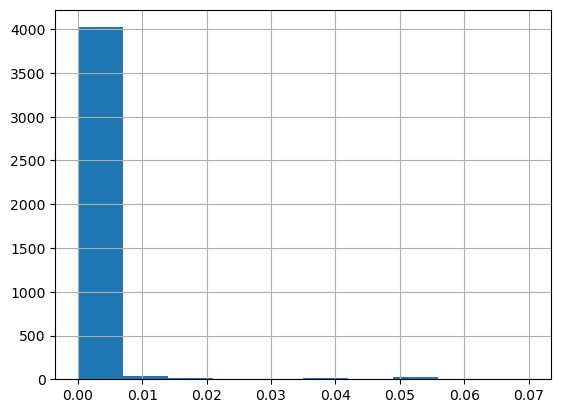

In [65]:
# Выведим распределение через hist
df["measurement_error"].hist()

In [57]:
# Выведим все что находится в пределах от единицы и далее по знаечнию
# Будем удалять значения, где ошибка строго выше 7%
print("Кол-во строк: ",len(df[df["measurement_error"]>0.07]))
index_to_remove = df[df["measurement_error"]>0.07].index
df = df.drop(index=index_to_remove)

Кол-во строк:  134


In [67]:
df.to_excel("./data_mod1_error_droped.xlsx")

### Добавим три колонки вместо raw_value "value_from", "value_to", "plus_minus"


In [ ]:
# "value_from" - значения от  
# "value_to" - значения до
# "plus_minus" - если +-, то предельное значение

In [96]:
# Переведем в соответсвиии с функицей ниже

def get_new_data_from_raw_value(row):
    values = re.findall(r"[+]?\d*\.?\d+|\d+", row['raw_value'])
    values = [float(x) for x in values]
    # remove 3 element column values
    if len(values) > 2:
        return [None,None,None]
    # if only one value    
    if len(values) == 1:
        return [values[0],values[0],0]
    # if this is value with error
    elif values[0] > values[1]:
        return [values[0]-values[1],values[0],values[0]+values[1]]
    # если интервал
    elif values[0] < values[1]:
        return [values[0],values[1],0]
    else:
        return [None,None,None]

In [95]:
df_copy1 = df.copy(deep=True)

In [97]:
# Новые заненяи у measurement_error
df_copy1[["value_from", "value_to", "plus_minus"]] = df_copy1.apply(lambda row: get_new_data_from_raw_value(row), axis=1,result_type="expand")

In [115]:
# Дропаю колонку raw_value - она больше не понадобится 
df_copy1 = df_copy1.drop(columns="raw_value")

In [102]:
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4138 entries, 0 to 4984
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     4138 non-null   object 
 1   Date                    4138 non-null   object 
 2   Journal                 4138 non-null   object 
 3   Title                   4138 non-null   object 
 4   Name                    4138 non-null   object 
 5   measurement_error       4138 non-null   float64
 6   measurement_wavelength  913 non-null    float64
 7   measurement_method      4138 non-null   object 
 8   normalised_name         3860 non-null   object 
 9   raw_value               4138 non-null   object 
 10  value_from              4129 non-null   float64
 11  value_to                4129 non-null   float64
 12  plus_minus              4129 non-null   float64
dtypes: float64(5), object(8)
memory usage: 452.6+ KB


In [101]:
df_copy1.to_excel("./data_mod1_raw_value_devided.xlsx")

In [103]:
# Удаляем строки с нулом
df_copy1 = df_copy1.dropna(subset=["value_from", "value_to", "plus_minus"])

In [112]:
# Теперь дропгем колонку plus_minus, но сначала найдем все строки
# Где значения plus_minus!=0, то есть тем самым мы удаляем данные с погрешностью
print("Кол-во погрешностей (plus_minus): ",sum(df_copy1["plus_minus"]!=0))
df_copy1 = df_copy1.drop(index=df_copy1[df_copy1["plus_minus"]!=0].index)
df_copy1 = df_copy1.drop(columns="plus_minus")

Кол-во погрешностей (plus_minus):  104


In [117]:
df_copy1.to_excel("./data_mod1_raw_value_devided.xlsx")

## Работа с выбросами

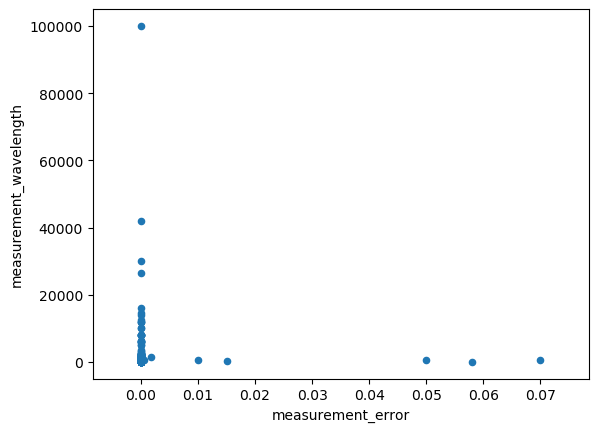

In [135]:
# Обратимся к колонкам measurement_error и measurement_wavelength
df_copy1.plot.scatter(x = 'measurement_error', y = 'measurement_wavelength')

In [145]:
df_copy1 = df_copy1[((df_copy1['measurement_wavelength']<20000) 
                     | (df_copy1['measurement_wavelength'].isna())) & (df_copy1['measurement_error']<0.01)]

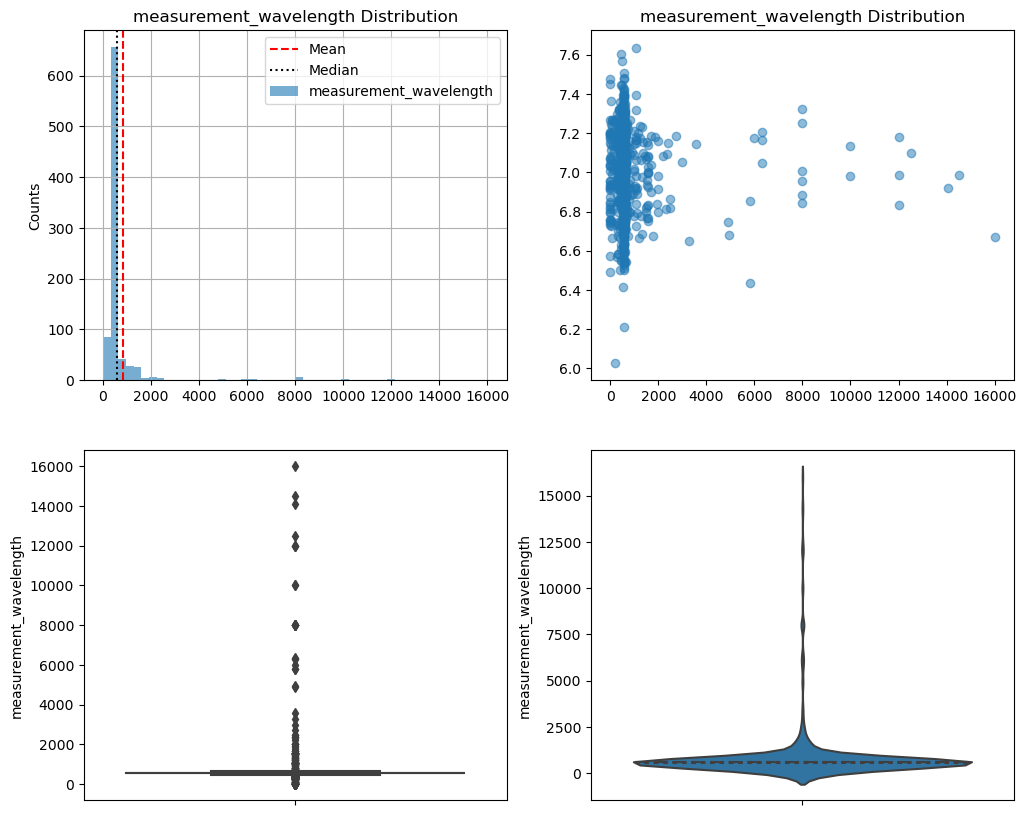

In [160]:
import seaborn as sns

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
df_copy1['measurement_wavelength'].hist(bins=50, label='measurement_wavelength', alpha=0.6)
plt.axvline(np.mean(df_copy1['measurement_wavelength']), ls='--', c='r', label="Mean")
plt.axvline(df_copy1['measurement_wavelength'].median(), ls=':', c='black', label="Median")
plt.ylabel("Counts")
plt.title("measurement_wavelength Distribution")
plt.legend()

plt.subplot(2, 2, 2)
plt.scatter(df_copy1['measurement_wavelength'], np.random.normal(7, 0.2, size=df_copy1.shape[0]), alpha=0.5)
plt.title("measurement_wavelength Distribution")

plt.subplot(2, 2, 3)
sns.boxplot(y="measurement_wavelength", data=df_copy1)

plt.subplot(2, 2, 4)
sns.violinplot(y="measurement_wavelength", data=df_copy1, inner="quartile", bw=0.2)

In [161]:
# По показателям выше видно, что лучше пропуски у параметра measurement_wavelength заменить на медиану
measurement_wavelength_meidan = df_copy1['measurement_wavelength'].median()
df_copy1['measurement_wavelength'] = df_copy1['measurement_wavelength'].fillna(measurement_wavelength_meidan)

In [162]:
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3978 entries, 0 to 4024
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     3978 non-null   object 
 1   Date                    3978 non-null   object 
 2   Journal                 3978 non-null   object 
 3   Title                   3978 non-null   object 
 4   Name                    3978 non-null   object 
 5   measurement_error       3978 non-null   float64
 6   measurement_wavelength  3978 non-null   float64
 7   measurement_method      3978 non-null   object 
 8   normalised_name         3712 non-null   object 
 9   value_from              3978 non-null   float64
 10  value_to                3978 non-null   float64
dtypes: float64(4), object(7)
memory usage: 372.9+ KB


In [163]:
df_copy1.to_excel("./data_mod1_raw_value_devided.xlsx")

### Трансформация признаков

In [170]:
# Закодируем признак - measurement_method
from sklearn import preprocessing
cat_method = preprocessing.LabelEncoder().fit_transform(df_copy1["measurement_method"].values)
df_copy1["method_categorical"] = cat_method
df_copy1 = df_copy1.drop(columns="measurement_method")

In [172]:
df_copy1 = df_copy1.dropna()

In [173]:
df_copy1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3712 entries, 0 to 4024
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DOI                     3712 non-null   object 
 1   Date                    3712 non-null   object 
 2   Journal                 3712 non-null   object 
 3   Title                   3712 non-null   object 
 4   Name                    3712 non-null   object 
 5   measurement_error       3712 non-null   float64
 6   measurement_wavelength  3712 non-null   float64
 7   normalised_name         3712 non-null   object 
 8   value_from              3712 non-null   float64
 9   value_to                3712 non-null   float64
 10  method_categorical      3712 non-null   int32  
dtypes: float64(4), int32(1), object(6)
memory usage: 333.5+ KB


In [175]:
df_copy1.to_excel("./data_mod1_raw_value_devided.xlsx")

### Нормализация

In [181]:
# Будем использовать MinMaxScaler, так как поработали с выбросами, а он к ним чувствителен
from sklearn.preprocessing import MinMaxScaler
scaler_mes_wlength = MinMaxScaler()
normalized_data = scaler_mes_wlength.fit_transform(df_copy1["measurement_wavelength"].values.reshape(-1,1))
df_copy1["measurement_wavelength"] = normalized_data

In [184]:
df_copy1["measurement_wavelength"][:5]

0    0.039563
1    0.039550
2    0.024750
3    0.000875
4    0.036812
Name: measurement_wavelength, dtype: float64

In [185]:
df_copy1.to_excel("./data_mod1_raw_value_devided.xlsx")